In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [3]:
# load dataset
transactions = pd.read_csv('customer_transaction_sanctions.csv')

In [4]:
# creating time features
transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
transactions['month'] = transactions['date'].dt.month
transactions['day'] = transactions['date'].dt.day
transactions['weekday'] = transactions['date'].dt.weekday

In [5]:
# customer features 
customer_stats = transactions.groupby('customer_id').agg({
    'amount_usd': ['sum', 'mean', 'std', 'count'],
    'channel': pd.Series.nunique,
    'merchant': pd.Series.nunique,
    'country': pd.Series.nunique,
}).reset_index()

customer_stats.columns = ['customer_id', 'total_spent', 'avg_spent', 'std_spent', 'num_txns',
                          'unique_channels', 'unique_merchants', 'unique_countries']

customer_stats.fillna(0, inplace=True)

In [6]:
# scale for anomaly
scaler = StandardScaler()
features_scaled = scaler.fit_transform(customer_stats.drop(columns=['customer_id']))

In [7]:
# train for detection
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
customer_stats['anomaly_score'] = model.fit_predict(features_scaled)

In [8]:
# review anomalies
anomalies = customer_stats[customer_stats['anomaly_score'] == -1]
print(anomalies)

    customer_id  total_spent      avg_spent      std_spent  num_txns  \
2         C0003    154024.94   38506.235000   74361.941830         4   
27        C0028     21835.84    2426.204444    1812.561989         9   
90        C0091     30773.69    4396.241429    3587.405899         7   
96        C0097     12996.10    3249.025000    3550.581566         4   
110       C0111    396382.90  198191.450000  279972.636760         2   
128       C0129    274913.40  137456.700000  190943.296815         2   
178       C0179     56838.17   14209.542500   26808.594460         4   
179       C0180    358152.79  119384.263333  202402.307206         3   
211       C0212     22819.47    4563.894000    6734.800116         5   
234       C0235    243588.47  121794.235000  171152.035619         2   
255       C0256      9403.24    1343.320000    1661.054986         7   
258       C0259    165164.55   82582.275000  110264.428336         2   
265       C0266     45520.15    9104.030000   17410.905328      

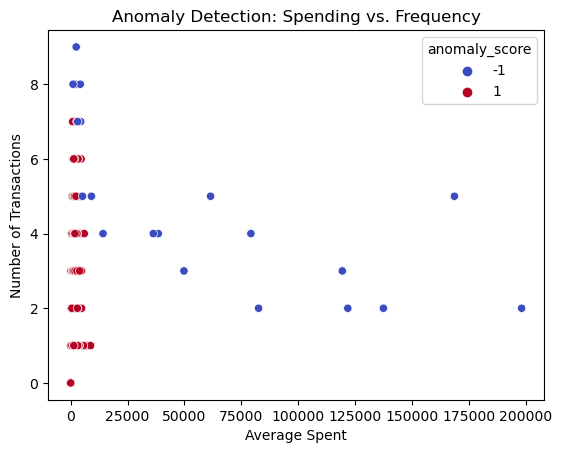

In [10]:
# visualize anomalies
sns.scatterplot(data=customer_stats, x='avg_spent', y='num_txns', hue='anomaly_score', palette='coolwarm')
plt.title('Anomaly Detection: Spending vs. Frequency')
plt.xlabel('Average Spent')
plt.ylabel('Number of Transactions')
plt.show()

In [20]:
# save as csv
anomalies.to_csv('flagged_customers.csv', index=False)